# Task 2: Quench Count Estimation via Multi-class Classification

### Problem Statement

The goal of this task is to estimate the number of quenches occurring within sequences that have already been classified as positive (i.e., containing at least one quench).

- **Input:** Sequences of heat maps labeled as containing quench(es).
- **Output:** A prediction of the exact number of quenches present in the sequence.

### Approach

This problem can be formulated as a **multi-class classification** task, where each class corresponds to a possible number of quenches (e.g., 1, 2, 3, ...). The model will learn to distinguish sequences based on how many distinct quench events they contain.

Using a multi-class classifier simplifies the prediction problem by directly assigning the sequence to one of the discrete count classes, rather than treating it as a regression problem.

---


In [1]:
from data.DataLoader import DataLoader
from data.torch_Dataset import torch_Dataset
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd

from utils.model_utils import count_parameters,reset_weights
from utils.seed import set_seed
set_seed(42)

Loading the dataset, by default converted in (N,24,15,15). Dataloader.get_data() returns a pandas dataframe with columns from the original dataset plus another one containing the number of quenches per sequence

In [2]:
dataloader = DataLoader("/auto_atlas/atlas/atlas_gen_fs/amilici/other_samples/ml_exam_dataset/data_quench.json") # transform_to_2d= True di default
data= dataloader.get_data()

# Taking only quenched sequences
data = data[data.label == 1].reset_index()

print(f"Dataset size: {len(data)}")
print(f"Dataset columns: {data.columns}")
data.head()

Dataset size: 300
Dataset columns: Index(['index', 'sequence', 'label', 'quench', 'num_quench'], dtype='object')


,index,sequence,label,quench,num_quench
0,8,"[[[22.582478486789327, 22.904808739314365, 22....",1,"[{'step': 18, 'pixel': [2, 1], 'temp': 25.1909...",1.0
1,9,"[[[22.0373877189044, 18.636944579237863, 21.76...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 25.0312...",7.0
2,20,"[[[21.411886934355916, 23.16618378647687, 20.1...",1,"[{'step': 14, 'pixel': [7, 7], 'temp': 24.8999...",1.0
3,21,"[[[21.276068279076245, 20.97700816985905, 21.2...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 24.4713...",2.0
4,23,"[[[21.69330864976891, 19.39115826850467, 20.55...",1,"[{'step': 15, 'pixel': [10, 13], 'temp': 25.69...",1.0


### Data preprocessing : min-max scaling

In [3]:
#Preprocessing: Normalizzazione dei dati
# Trova min e max globali su tutto il dataset

all_values = np.concatenate([sequence.flatten() for sequence in data.sequence])
global_min = np.min(all_values)
global_max = np.max(all_values)
denom = global_max - global_min
data.sequence = (data.sequence- global_min)/denom

def power_transform(sequence, power=2):
    return sequence ** power

# Applica la trasformazione di potenza
#data.sequence = data.sequence.apply(lambda x: power_transform(x,power=3))


# Data Augmentation

To increase the size and diversity of the training data, we apply several augmentation operations on the heat map sequences. This helps improve model robustness and generalization.

### Augmentation operations used:
- Rotations: 90°, 180°, 270°
- Flips: horizontal, vertical, diagonal (secondary)
- Time reversal (reversing sequence order)
- Combined reverse and flip
- Transpose spatial grid
- Adding Gaussian noise
- Shuffling time steps



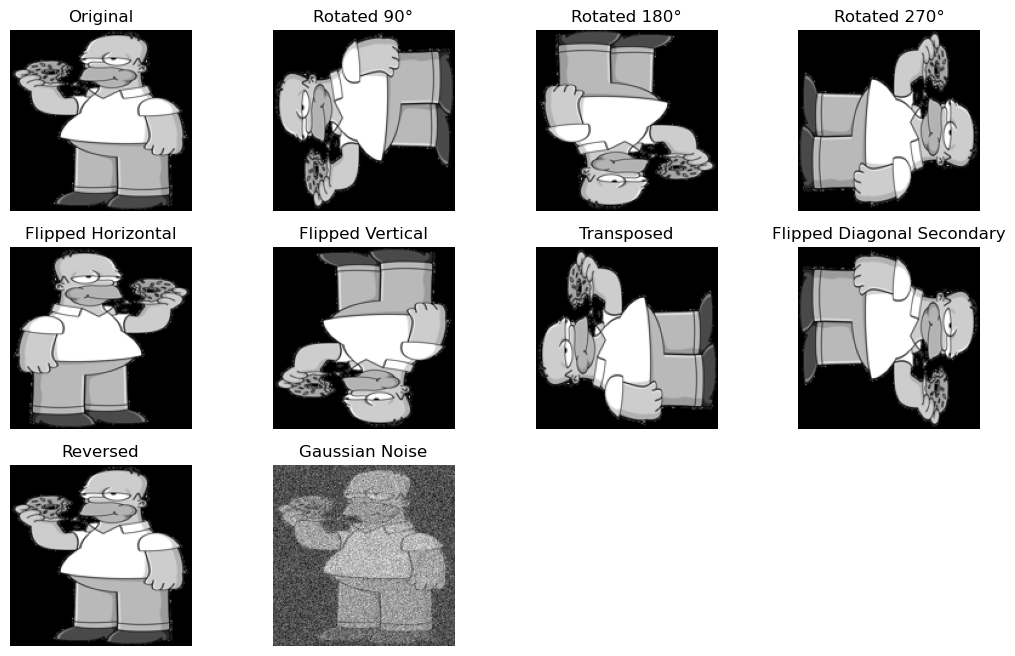

In [4]:
from data.augmentation import *
# esempio d'uso:
from PIL import Image
img_original = Image.open('homer.png')
img_small = np.array(img_original.convert('L').resize((150, 150)))

seq =img_small.reshape(1, 150, 150)  # Aggiungo la dimensione batch
seq_rot_90 = rotate_90(seq)
seq_rotate_270 = rotate_270(seq)
seq_rotate_180 = rotate_180(seq)

seq_flip_horizontal = flip_horizontal(seq)
seq_flip_vertical = flip_vertical(seq)
seq_transpose = transpose(seq)
seq_flip_diagonal_secondary = flip_diagonal_secondary(seq)

seq_noise = add_gaussian_noise(seq, mean=seq.mean(), std=50)
seq_reverse = time_reversal(seq)




plt.figure(figsize=(13, 8))
# Prima riga: 3 immagini
plt.subplot(3, 4, 1)
plt.imshow(seq[0], cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(3, 4, 2)
plt.imshow(seq_rot_90[0], cmap='gray')
plt.axis('off')
plt.title('Rotated 90°')


plt.subplot(3, 4, 3)
plt.imshow(seq_rotate_180[0], cmap='gray')
plt.axis('off')
plt.title('Rotated 180°')

plt.subplot(3, 4, 4)
plt.imshow(seq_rotate_270[0], cmap='gray')
plt.axis('off')
plt.title('Rotated 270°')

plt.subplot(3, 4, 5)
plt.imshow(seq_flip_horizontal[0], cmap='gray')
plt.axis('off')
plt.title('Flipped Horizontal')

plt.subplot(3, 4, 6)
plt.imshow(seq_flip_vertical[0], cmap='gray')
plt.axis('off')
plt.title('Flipped Vertical')

plt.subplot(3, 4, 7)
plt.imshow(seq_transpose[0], cmap='gray')
plt.axis('off')
plt.title('Transposed')

plt.subplot(3, 4, 8)
plt.imshow(seq_flip_diagonal_secondary[0], cmap='gray')
plt.axis('off')
plt.title('Flipped Diagonal Secondary')

plt.subplot(3, 4, 9)
plt.imshow(seq_reverse[0], cmap='gray')
plt.axis('off')
plt.title('Reversed')


plt.subplot(3, 4, 10)
plt.imshow(seq_noise[0], cmap='gray')
plt.axis('off')
plt.title('Gaussian Noise')

plt.show()


In [5]:
# Adding a column to distinguish augmented data from original data
data['augmented']= False
data.head()

,index,sequence,label,quench,num_quench,augmented
0,8,"[[[0.5438055558241474, 0.5755248699113726, 0.4...",1,"[{'step': 18, 'pixel': [2, 1], 'temp': 25.1909...",1.0,False
1,9,"[[[0.49016521292383064, 0.15554032699428255, 0...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 25.0312...",7.0,False
2,20,"[[[0.42861202115397634, 0.6012458103150874, 0....",1,"[{'step': 14, 'pixel': [7, 7], 'temp': 24.8999...",1.0,False
3,21,"[[[0.41524661548084363, 0.38581722912660055, 0...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 24.4713...",2.0,False
4,23,"[[[0.456305679171562, 0.22975967411212875, 0.3...",1,"[{'step': 15, 'pixel': [10, 13], 'temp': 25.69...",1.0,False


In [6]:
operations = [rotate_90, rotate_180,rotate_270, flip_horizontal, 
              flip_vertical, time_reversal,reverse_and_flip,add_gaussian_noise,
              transpose,flip_diagonal_secondary,shuffle]

def data_augmentation(data, operations):
    all_datasets= [data]
    for op in operations:
        op_data = pd.DataFrame({
        'sequence': [op(seq) for seq in data.sequence],
        'label': data.label,
        'quench': data.quench,
        'num_quench': data.num_quench,
        'augmented': True   
        })
        all_datasets.append(op_data)
    augmented_data = pd.concat(all_datasets, ignore_index=True) 
    return augmented_data.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset

In [7]:
augmented_data = data_augmentation(data, operations)
print(f"Augmented dataset size: {len(augmented_data)}")

Augmented dataset size: 3600


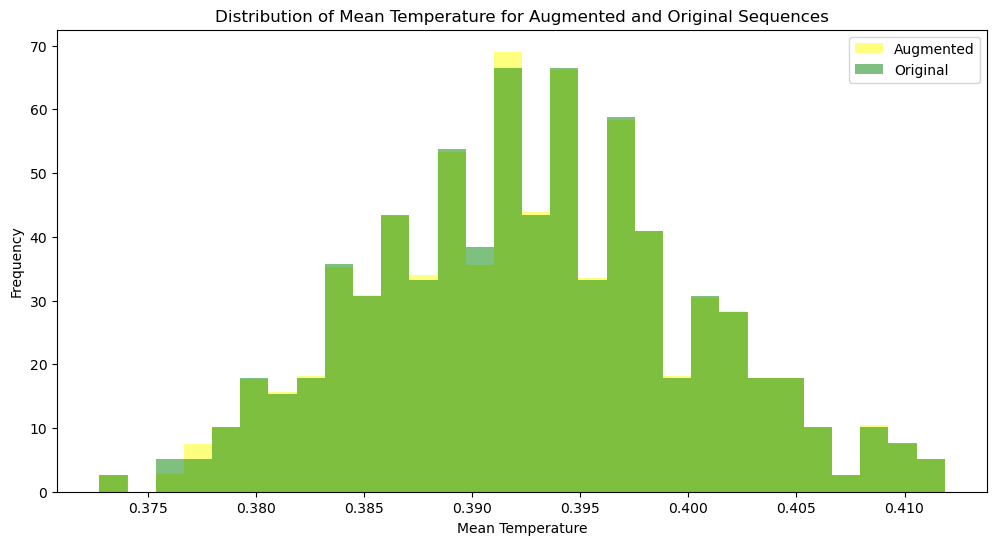

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Estrai sequenze aumentate e non aumentate come liste
seq_aug = augmented_data[augmented_data['augmented'] == True]['sequence'].tolist()
seq_orig = augmented_data[augmented_data['augmented'] == False]['sequence'].tolist()

# Converti in array 4D
seq_aug_array = np.array(seq_aug)   # shape (N_aug, 24, 15, 15)
seq_orig_array = np.array(seq_orig) # shape (N_orig, 24, 15, 15)

# Calcola media temperatura totale per ogni sequenza
mean_aug = seq_aug_array.mean(axis=(1,2,3))
mean_orig = seq_orig_array.mean(axis=(1,2,3))

plt.figure(figsize=(12, 6))
plt.hist(mean_aug, bins=30, alpha=0.5, label='Augmented', color='yellow',density=True)
plt.hist(mean_orig, bins=30, alpha=0.5, label='Original', color='green',density=True)   
plt.xlabel('Mean Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Temperature for Augmented and Original Sequences')
plt.legend()
plt.show()


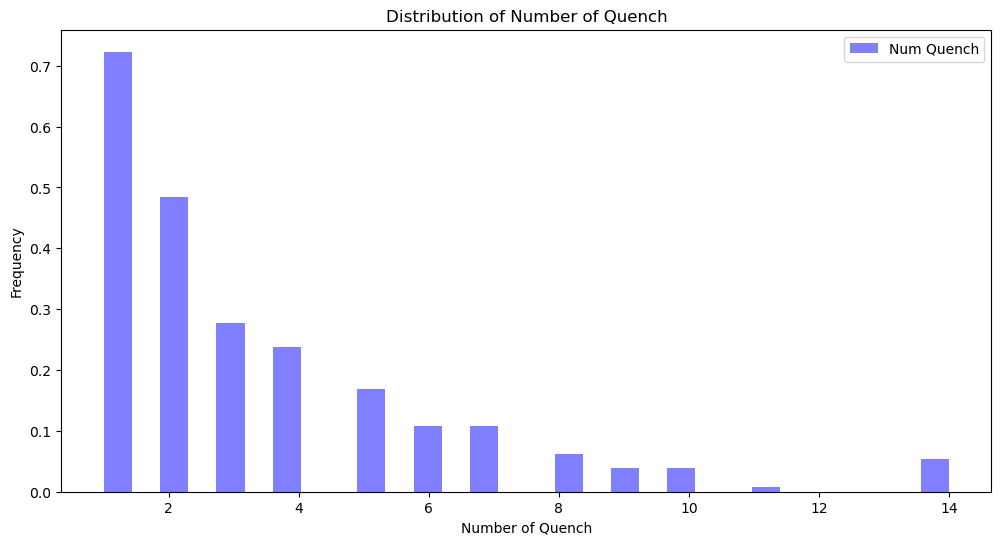

In [9]:
# Plotting distribution of num_quench
plt.figure(figsize=(12, 6))
plt.hist(augmented_data['num_quench'], bins=30, alpha=0.5, label='Num Quench', color='blue', density=True)
plt.xlabel('Number of Quench')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Quench')
plt.legend()
plt.show()



In [10]:
from data.torch_Dataset import torch_Dataset_task2
# Crea il dataset PyTorch
dataset = torch_Dataset_task2(augmented_data)

# Dividi il dataset in training e validation
train_size = int(0.85 * len(dataset))
val_size= int(0.075 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
# Crea i DataLoader
batch_size = 32
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



Training set size: 3060
Validation set size: 270
Test set size: 270


In [11]:
len(test_dataset.dataset)

3600

In [12]:
from models.DeepCNN3D import DeepCNN3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepCNN3D(num_classes=14).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    correct = 0
   
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).long() - 1  # se label da 1 a 14, porto a 0-13
      
        
        optimizer.zero_grad()
        outputs = model(inputs)
        #print('outputs: ',nn.Softmax(dim=1)(outputs),"\n labels: " ,labels.squeeze().long())
        #print("\n")
        
        loss = criterion(outputs, labels.squeeze().long())
        loss.backward()
        optimizer.step()
        
        
        train_loss += loss.item() 
        _, predicted = nn.Softmax(dim=1)(outputs).max(1)
        
        correct += (predicted==labels.squeeze().long()).sum().item()
        
    epoch_loss = train_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).long() - 1
          
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze().long())
            
            val_loss += loss.item()
           
            _,predicted = nn.Softmax(dim=1)(outputs).max(1)
            correct+= (predicted==labels.squeeze().long()).sum().item()
            
            
    epoch_loss = val_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc


In [14]:
num_epochs = 400
val_losses = []
train_losses = []

for epoch in range(num_epochs):

    if epoch == 0:
        reset_weights(model)  # Reset weights at the beginning of each epoch

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    scheduler.step()  # Update learning rate
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Train acc: {100*train_acc:.4f}%| Val acc: {100*val_acc:.4f}%")

Epoch 1/400
Train loss: 0.0691 | Val loss: 0.0750 | Train acc: 30.7516%| Val acc: 32.9630%
Epoch 2/400
Train loss: 0.0629 | Val loss: 0.0710 | Train acc: 31.2745%| Val acc: 32.9630%
Epoch 3/400
Train loss: 0.0597 | Val loss: 0.0673 | Train acc: 31.3399%| Val acc: 32.9630%
Epoch 4/400
Train loss: 0.0536 | Val loss: 0.0597 | Train acc: 33.2680%| Val acc: 36.6667%
Epoch 5/400
Train loss: 0.0496 | Val loss: 0.0553 | Train acc: 38.4967%| Val acc: 38.8889%
Epoch 6/400
Train loss: 0.0440 | Val loss: 0.0500 | Train acc: 43.1046%| Val acc: 46.6667%
Epoch 7/400
Train loss: 0.0423 | Val loss: 0.0476 | Train acc: 45.0327%| Val acc: 41.8519%
Epoch 8/400
Train loss: 0.0394 | Val loss: 0.0452 | Train acc: 48.4314%| Val acc: 46.6667%
Epoch 9/400
Train loss: 0.0374 | Val loss: 0.0434 | Train acc: 50.3595%| Val acc: 58.5185%
Epoch 10/400
Train loss: 0.0353 | Val loss: 0.0426 | Train acc: 52.4510%| Val acc: 52.2222%
Epoch 11/400
Train loss: 0.0343 | Val loss: 0.0430 | Train acc: 53.3987%| Val acc: 45.925

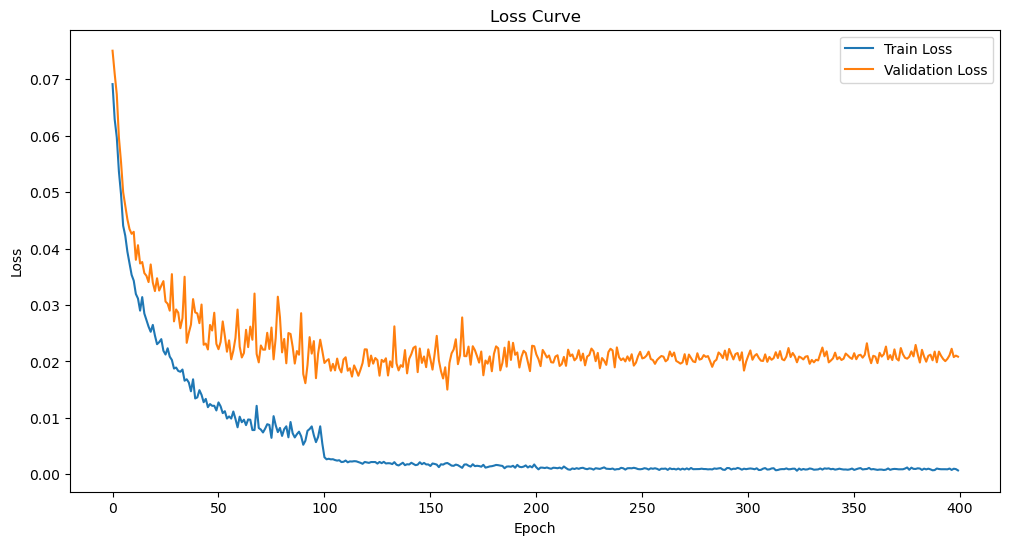

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [16]:
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f} - Test accuracy: {test_acc:.4f}")


Test loss: 0.0285 - Test accuracy: 0.7704


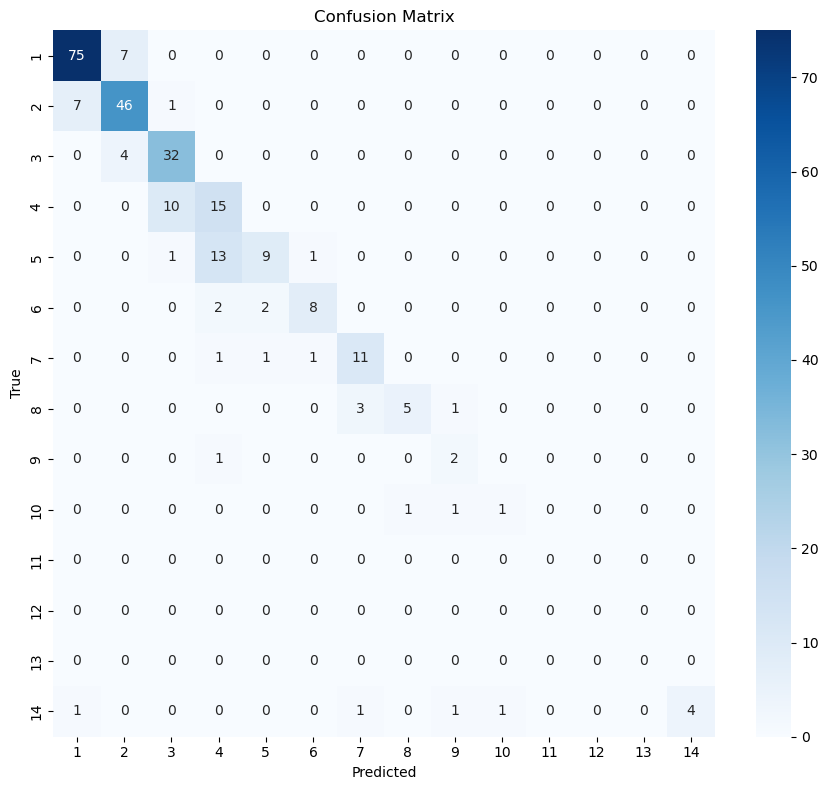

In [17]:
# test performance and confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def test_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).long() - 1
            
            outputs = model(inputs)
            _, predicted = nn.Softmax(dim=1)(outputs).max(1)
            
            all_labels.extend(labels.squeeze().long().cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

all_labels, all_preds = test_model(model, test_loader, device)
all_labels = all_labels + 1  # Convert back to original labels (1-14)
all_preds = all_preds + 1  # Convert back to original labels (1-14)

from utils.plot import plot_confusion_matrix
plot_confusion_matrix(all_labels, all_preds, classes=list(range(1, 15)))



In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report



# Accuracy generale
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.2f}")

# Precision, Recall, F1 - macro-average (tutte le classi uguale peso)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print(f"Precision (macro): {precision_macro:.2f}")
print(f"Recall (macro): {recall_macro:.2f}")
print(f"F1-score (macro): {f1_macro:.2f}")

# Genera report come dizionario
report_dict = classification_report(all_labels, all_preds, output_dict=True)

# Converti in DataFrame e togli la riga 'accuracy' (non è per classe)
df_report = pd.DataFrame(report_dict).transpose().drop('accuracy', errors='ignore')

# Mostra la tabella in Jupyter (automaticamente formattata in HTML)
df_report

Accuracy: 0.77
Precision (macro): 0.72
Recall (macro): 0.65
F1-score (macro): 0.66


,precision,recall,f1-score,support
1,0.903614,0.914634,0.909091,82.0
2,0.807018,0.851852,0.828829,54.0
3,0.727273,0.888889,0.800000,36.0
4,0.468750,0.600000,0.526316,25.0
5,0.750000,0.375000,0.500000,24.0
6,0.800000,0.666667,0.727273,12.0
7,0.733333,0.785714,0.758621,14.0
8,0.833333,0.555556,0.666667,9.0
9,0.400000,0.666667,0.500000,3.0
10,0.500000,0.333333,0.400000,3.0
